# Mean-Variance Optimization

MPT solves for the optimal portfolio weights to minimize volatility for a given expected return, or maximize returns for a given level of volatility. The key requisite input are expected asset returns, standard deviations, and the covariance matrix. 

Diversification works because the variance of portfolio returns depends on the covariance of the assets and can be reduced below the weighted average of the asset variances by including assets with less than perfect correlation. In particular, given a vector, ω, of portfolio weights and the covariance matrix, $\Sigma$, the portfolio variance, $\sigma_{\text{PF}}$ is defined as:
$$\sigma_{\text{PF}}=\omega^T\Sigma\omega$$

Markowitz showed that the problem of maximizing the expected portfolio return subject to a target risk has an equivalent dual representation of minimizing portfolio risk subject to a target expected return level, μPF. Hence, the optimization problem becomes:
$$
\begin{align}
\min_\omega & \quad\quad\sigma^2_{\text{PF}}= \omega^T\Sigma\omega\\
\text{s.t.} &\quad\quad \mu_{\text{PF}}= \omega^T\mu\\ 
&\quad\quad \lVert\omega\rVert =1
\end{align}
$$

We can calculate an efficient frontier using `scipy.optimize.minimize` and the historical estimates for asset returns, standard deviations, and the covariance matrix. 

## Imports & Settings

In [2]:
import warnings

import pandas as pd  
import numpy as np
from numpy.random import random, uniform, normal, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
from itertools import repeat, product
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use('fivethirtyeight')
np.random.seed(42)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [4]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

## Prepare Data

We select historical data for tickers included in the S&P500 (according to Wikipedia) from 1998-2017.

In [65]:
from quantrocket.fundamental import download_sharadar_sp500, get_sharadar_sp500_reindexed_like
download_sharadar_sp500(filepath_or_buffer="sp500_changes.csv", start_date="1988-01-01")
sp500_changes = pd.read_csv("sp500_changes.csv", parse_dates=["DATE"])
sp500_changes.head()

,Sid,DATE,ACTION,TICKER,NAME,CONTRATICKER,CONTRANAME,NOTE
0,FIBBG000F5VJX9,1988-02-11,added,IKN,Ikon Office Solutions Inc,NaN,NaN,NaN
1,FIBBG000BLCPY4,1988-02-11,added,HP,Helmerich & Payne Inc,WSN,Western Company Of North America,NaN
2,FIBBG000BG5X85,1988-02-25,added,CPQ,Compaq Computer Corp,NaN,NaN,NaN
3,FIBBG000BKZB36,1988-03-31,added,HD,Home Depot Inc,NaN,NaN,NaN
4,FIBBG000BQK1M0,1988-04-28,added,ONE1,Bank One Corp,NaN,NaN,NaN


In [68]:
from quantrocket import get_prices
prices = get_prices("usstock-1d", start_date="1988-01-01", fields="Close")
closes = prices.loc["Close"] # for intraday databases also isolate a time with .xs
from quantrocket.fundamental import get_sharadar_sp500_reindexed_like
are_in_sp500 = get_sharadar_sp500_reindexed_like(closes)

In [70]:
prices

Sid               FIBBG000001346  FIBBG000001382  FIBBG000001444  \
Field Date                                                         
Close 2007-01-03             NaN             NaN             NaN   
      2007-01-04             NaN             NaN             NaN   
      2007-01-05             NaN             NaN             NaN   
      2007-01-08             NaN             NaN             NaN   
      2007-01-09             NaN             NaN             NaN   
...                          ...             ...             ...   
      2023-05-05             NaN             NaN             NaN   
      2023-05-08             NaN             NaN             NaN   
      2023-05-09             NaN             NaN             NaN   
      2023-05-10             NaN             NaN             NaN   
      2023-05-11             NaN             NaN             NaN   

Sid               FIBBG0000014K6  FIBBG0000014P1  FIBBG0000014Y1  \
Field Date                                                         
Close 2007-01-03          19.990             NaN             NaN   
      2007-01-04             NaN             NaN          20.133   
      2007-01-05          20.136             NaN          20.133   
      2007-01-08             NaN             NaN          20.140   
      2007-01-09             NaN             NaN          20.140   
...                          ...             ...             ...   
      2023-05-05             NaN             NaN             NaN   
      2023-05-08             NaN             NaN             NaN   
      2023-05-09             NaN             NaN             NaN   
      2023-05-10             NaN             NaN             NaN   
      2023-05-11             NaN             NaN             NaN   

Sid               FIBBG0000014Z0  FIBBG000001514  FIBBG0000016D9  \
Field Date                                                         
Close 2007-01-03          19.566          25.270             NaN   
      2007-01-04          19.731          25.270             NaN   
      2007-01-05          19.618          25.320             NaN   
      2007-01-08          19.671          25.300             NaN   
      2007-01-09          19.701          25.370             NaN   
...                          ...             ...             ...   
      2023-05-05             NaN             NaN             NaN   
      2023-05-08             NaN             NaN             NaN   
      2023-05-09             NaN             NaN             NaN   
      2023-05-10             NaN             NaN             NaN   
      2023-05-11             NaN             NaN             NaN   

Sid               FIBBG000001701  ...  QI000000252817  QI000000253003  \
Field Date                        ...                                   
Close 2007-01-03          25.600  ...             NaN             NaN   
      2007-01-04          25.600  ...             NaN             NaN   
      2007-01-05          25.620  ...             NaN             NaN   
      2007-01-08          25.500  ...             NaN             NaN   
      2007-01-09          25.580  ...             NaN             NaN   
...                          ...  ...             ...             ...   
      2023-05-05             NaN  ...           0.040           0.035   
      2023-05-08             NaN  ...           0.042           0.060   
      2023-05-09             NaN  ...           0.044           0.060   
      2023-05-10             NaN  ...             NaN             NaN   
      2023-05-11             NaN  ...           0.040             NaN   

Sid               QI000000253488  QI000000254586  QI000000255110  \
Field Date                                                         
Close 2007-01-03             NaN             NaN             NaN   
      2007-01-04             NaN             NaN             NaN   
      2007-01-05             NaN             NaN             NaN   
      2007-01-08             NaN             NaN       

In [73]:
prices = prices.droplevel(0).filter(are_in_sp500).sample(n=50, axis=1)

In [74]:
prices

Sid,FIBBG000BRWGM2,FIBBG000BW2FF4,FIBBG00VT0RPQ6,FIBBG000005F63,FIBBG00Z8MRWF9,FIBBG00GVM4PF5,FIBBG011X01Y30,FIBBG000BLP360,FIBBG000BPGQ60,FIBBG000BG09F5,...,FIBBG006WY0XK1,FIBBG00NJD1T78,FIBBG011MFG4L9,FIBBG00MNV4MH6,FIBBG011HTSHK4,FIBBG000QCG7M7,FIBBG000BMQZT1,FIBBG000C2HWL9,FIBBG00YDFYTQ8,FIBBG00XS6PB10
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,22.480,29.335,NaN,NaN,NaN,NaN,NaN,12.798,11.630,13.180,...,NaN,NaN,NaN,NaN,NaN,NaN,5.190,6.850,NaN,NaN
2007-01-04,23.360,29.068,NaN,NaN,NaN,NaN,NaN,12.978,11.692,12.350,...,NaN,NaN,NaN,NaN,NaN,NaN,5.130,6.620,NaN,NaN
2007-01-05,22.640,28.515,NaN,NaN,NaN,NaN,NaN,12.350,11.636,12.400,...,NaN,NaN,NaN,NaN,NaN,NaN,4.980,6.460,NaN,NaN
2007-01-08,22.490,28.506,NaN,NaN,NaN,NaN,NaN,12.857,11.748,12.440,...,NaN,NaN,NaN,NaN,NaN,NaN,4.930,6.360,NaN,NaN
2007-01-09,22.520,28.640,NaN,NaN,NaN,NaN,NaN,12.808,11.692,12.240,...,NaN,NaN,NaN,NaN,NaN,NaN,4.910,6.270,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-05,4.710,98.880,NaN,NaN,NaN,NaN,24.435,NaN,73.579,NaN,...,NaN,0.040,37.665,0.268,NaN,NaN,NaN,3.920,3.050,132.830
2023-05-08,4.740,95.570,NaN,NaN,NaN,NaN,24.420,NaN,73.739,NaN,...,NaN,0.034,37.525,NaN,NaN,NaN,NaN,3.870,3.420,133.180
2023-05-09,4.860,95.410,NaN,NaN,NaN,NaN,24.245,NaN,73.898,NaN,...,NaN,0.040,37.490,NaN,NaN,NaN,NaN,3.910,3.310,132.320


## Compute Inputs

### Compute Returns

In [75]:
start = 1988
end = 2023

Create month-end monthly returns and drop dates that have no observations:

In [76]:
monthly_returns = prices.loc[f'{start}':f'{end}'].resample('M').last().pct_change().dropna(how='all')
monthly_returns = monthly_returns.dropna(axis=1)
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 196 entries, 2007-02-28 to 2023-05-31
Freq: M
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FIBBG000BRWGM2  196 non-null    float64
 1   FIBBG000BW2FF4  196 non-null    float64
 2   FIBBG000BLP360  196 non-null    float64
 3   FIBBG000BPGQ60  196 non-null    float64
 4   FIBBG000BG09F5  196 non-null    float64
 5   FIBBG000BTCXB5  196 non-null    float64
 6   FIBBG000C4JX31  196 non-null    float64
 7   FIBBG0000089F4  196 non-null    float64
 8   FIBBG000H7P686  196 non-null    float64
 9   FIBBG000KZ47S9  196 non-null    float64
 10  FIBBG000BG9MK1  196 non-null    float64
 11  FIBBG000C6N961  196 non-null    float64
 12  FIBBG000BJ26K7  196 non-null    float64
 13  FIBBG000BNZLT0  196 non-null    float64
 14  FIBBG000C6QMQ7  196 non-null    float64
 15  FIBBG000F4DQQ4  196 non-null    float64
 16  FIBBG000BS8F94  196 non-null    float64
 17  FIBBG000

### Set  Parameters

In [77]:
stocks = monthly_returns.columns

In [78]:
n_obs, n_assets = monthly_returns.shape
n_assets, n_obs

(19, 196)

In [79]:
NUM_PF = 100000 # no of portfolios to simulate

In [80]:
x0 = uniform(-1, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [81]:
periods_per_year = round(monthly_returns.resample('A').size().mean())
periods_per_year

12

### Compute Covariance

In [82]:
mean_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

In [83]:
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

### Risk-Free Rate

In [84]:
rf_rate = treasury_10yr_monthly.mean()

In [85]:
alpha = np.full(shape=n_assets, fill_value=.01)
weights = dirichlet(alpha=alpha, size=NUM_PF)
weights *= choice([-1, 1], size=weights.shape)
weights.shape

(100000, 19)

## Simulate Random Portfolios

The simulation generates random weights using the Dirichlet distribution, and computes the mean, standard deviation, and SR for each sample portfolio using the historical return data:

In [86]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.025)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ monthly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std

    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [87]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

### Plot Simulated Portfolios

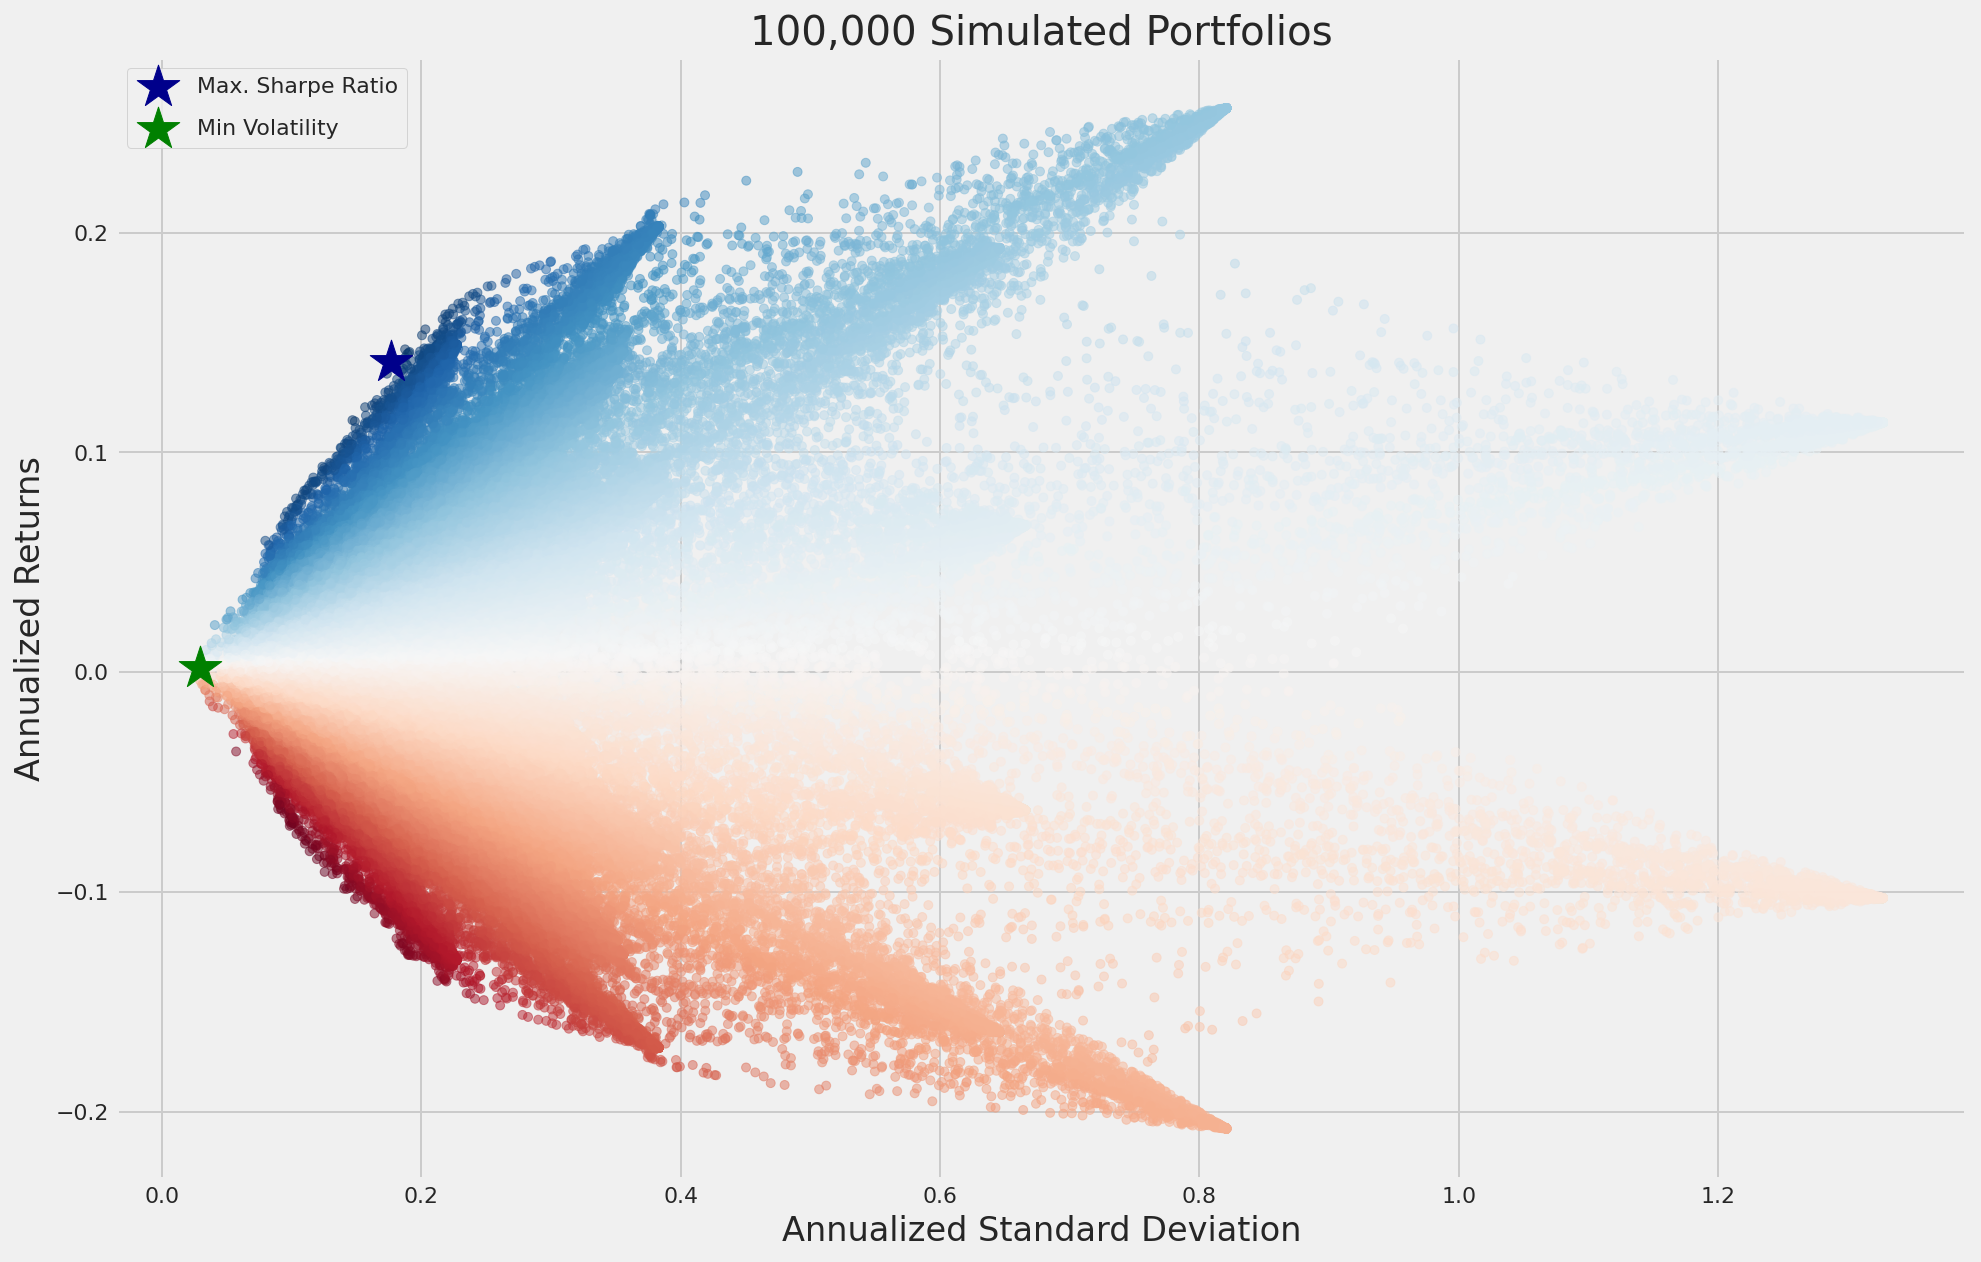

In [88]:
# pandas 0.24 will fix bug with colorbars: https://github.com/pandas-dev/pandas/pull/20446
ax = simul_perf.plot.scatter(x=0, y=1, c=2,
                             cmap='RdBu',
                             alpha=0.5, figsize=(14, 9), colorbar=False,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
ax.scatter(sd, r, marker='*', color='darkblue',
           s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

## Compute Annualize PF Performance

Set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR. 

To this end, define the functions that measure the key metrics:

In [89]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [90]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [91]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize given the constraints that the weights are bounded by, [-1, 1], and sum to one in absolute terms

In [92]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

In [93]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x)) - 1}

In [94]:
def max_sharpe_ratio(mean_ret, cov, short=True):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Compute Efficient Frontier

The solution requires iterating over ranges of acceptable values to identify optimal risk-return combinations

In [95]:
def min_vol_target(mean_ret, cov, target, short=True):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq', 'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

The mean-variance frontier relies on in-sample, backward-looking optimization. In practice, portfolio optimization requires forward-looking input. Expected returns are notoriously difficult to estimate accurately.

The covariance matrix can be estimated somewhat more reliably, which has given rise to several alternative approaches. However, covariance matrices with correlated assets pose computational challenges since the optimization problem requires inverting the matrix. The high condition number induces numerical instability, which in turn gives rise to Markovitz curse: the more diversification is required (by correlated investment opportunities), the more unreliable the weights produced by the algorithm. 

## Min Volatility Portfolio

In [96]:
def min_vol(mean_ret, cov, short=True):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [97]:
def efficient_frontier(mean_ret, cov, ret_range, short=True):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Run Calculation

### Get random PF

In [98]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=True)

In [99]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns  Sharpe Ratio
count                     100000.000          100000.000    100000.000
mean                           0.323               0.004        -0.007
std                            0.242               0.092         0.313
min                            0.030              -0.208        -0.783
25%                            0.162              -0.063        -0.273
50%                            0.269              -0.000        -0.021
75%                            0.364               0.067         0.275
max                            1.327               0.257         0.764


In [100]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation   0.154
Annualized Returns              0.121
Sharpe Ratio                    0.764
Name: 5005, dtype: float64

### Get Max Sharpe PF

In [101]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [102]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret   0.097
sd    0.107
sr    0.873
dtype: float64

From simulated pf data

### Get Min Vol PF

In [103]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

### Get Efficent PFs

In [104]:
ret_range = np.linspace(0, simul_perf.iloc[:, 1].max() * 1.1, 25)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range,short=False)

### Plot Result

The simulation yields a subset of the feasible portfolios, and the efficient frontier identifies the optimal in-sample return-risk combinations that were achievable given historic data. 

The below figure shows the result including the minimum variance portfolio and the portfolio that maximizes the SR and several portfolios produce by alternative optimization strategies. The efficient frontier 

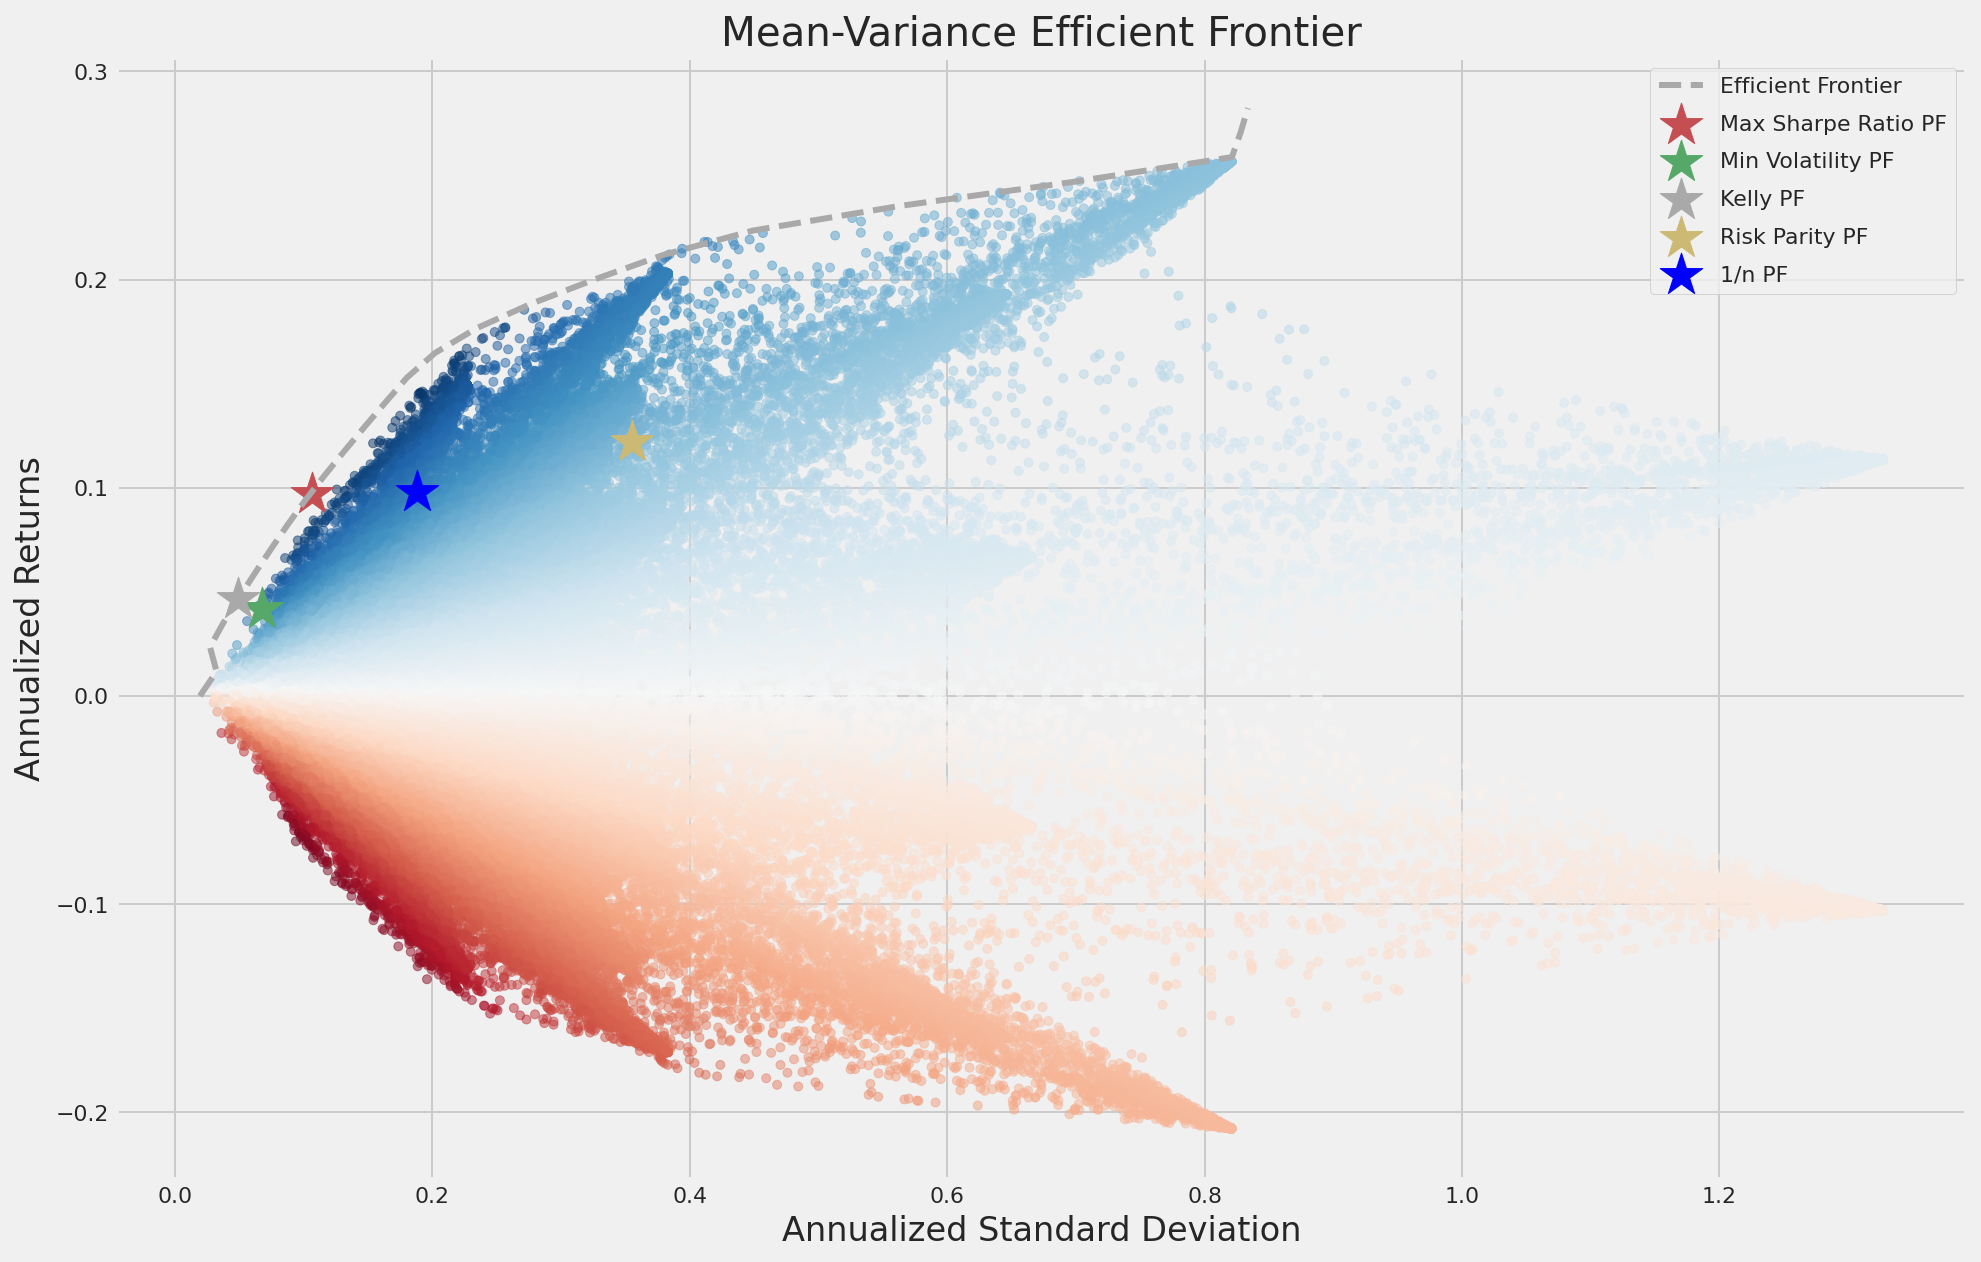

In [105]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax,
                                 cmap='RdBu',
                                 alpha=0.5, figsize=(14, 9), colorbar=False,
                                 title='Mean-Variance Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='r', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='*', color='g', s=500, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='*', color='darkgrey', s=500, label='Kelly PF')

std = monthly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='*', color='y', s=500, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='*', color='blue', s=500, label='1/n PF')

ax.plot([p['fun'] for p in eff_pf], ret_range, 
        linestyle='--', lw=3, color='darkgrey', label='Efficient Frontier')
ax.legend(labelspacing=0.8)
fig.tight_layout();

In [106]:
std = monthly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
r, sd

(0.12217596226183813, 0.35538169926533153)